In [24]:
import tensorflow as tf

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Finished Loading.")

Finished Loading.


In [25]:
import cv2
import numpy as np
import tensorflow as tf
from skimage import color, feature
from sklearn import svm, tree
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Flatten the label arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Convert images to HSV
def convert_to_hsv(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in images])

hsv_train = convert_to_hsv(x_train)
hsv_test = convert_to_hsv(x_test)

# Define functions for feature extraction
def extract_hog_features(images):
    return np.array([feature.hog(color.rgb2gray(img.astype('float') / 255), orientations=20, pixels_per_cell=(8, 8),
                                 cells_per_block=(1, 1), visualize=False) for img in images])

def extract_lbp_features(images):
    return np.array([np.histogram(feature.local_binary_pattern(color.rgb2gray(img), 24, 3, method="uniform").ravel(),
                                  bins=np.arange(0, 25), range=(0, 24))[0] / img.size for img in images])

# Initialize feature extractors and spaces for RGB and HSV images
feature_extractors = [extract_hog_features, extract_lbp_features]
spaces = [('RGB', x_train, x_test), ('HSV', hsv_train, hsv_test)]

for feature_name, train_images, test_images in spaces:
    for extractor in feature_extractors:
        # Extract features
        train_features = extractor(train_images)
        test_features = extractor(test_images)

        # Initialize and fit models
        for model_class in [svm.SVC, tree.DecisionTreeClassifier]:
            model = model_class(C=10, gamma=0.1, kernel='rbf') if model_class is svm.SVC else model_class(max_features=None)
            model.fit(train_features, y_train)
            
            # Predict and evaluate
            y_pred = model.predict(test_features)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"Model: {model_class.__name__}, Feature: {feature_name}-{extractor.__name__}, "
                  f"Accuracy: {accuracy:.2f}")


Model: SVC, Feature: RGB-extract_hog_features, Accuracy: 0.56
Model: DecisionTreeClassifier, Feature: RGB-extract_hog_features, Accuracy: 0.22


C:\Users\周以恆\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Model: SVC, Feature: RGB-extract_lbp_features, Accuracy: 0.17
Model: DecisionTreeClassifier, Feature: RGB-extract_lbp_features, Accuracy: 0.17
Model: SVC, Feature: HSV-extract_hog_features, Accuracy: 0.44
Model: DecisionTreeClassifier, Feature: HSV-extract_hog_features, Accuracy: 0.17


C:\Users\周以恆\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Model: SVC, Feature: HSV-extract_lbp_features, Accuracy: 0.13
Model: DecisionTreeClassifier, Feature: HSV-extract_lbp_features, Accuracy: 0.14


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from skimage import color, feature
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

def extract_hog_features_color(images):
    """ Extract HOG features from each color channel of images and aggregate them into one vector per image. """
    hog_descriptors = []
    for img in images:
        img_features = []  # Collect features for all channels of a single image here
        for channel in range(img.shape[-1]):
            hog_desc = feature.hog(img[:, :, channel], orientations=20, pixels_per_cell=(8, 8),
                                   cells_per_block=(1, 1), visualize=False, channel_axis=None)
            img_features.extend(hog_desc)  # Extend the feature vector with features from this channel
        hog_descriptors.append(img_features)  # Append the complete feature vector for this image
    return np.array(hog_descriptors)

def extract_lbp_features_color(images):
    lbp_descriptors = []
    for img in images:
        img_features = []  # This will hold all LBP features for the current image
        for channel in range(img.shape[-1]):
            lbp = feature.local_binary_pattern(img[:, :, channel], 24, 3, method="uniform")
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            img_features.extend(hist)
        lbp_descriptors.append(img_features)
    return np.array(lbp_descriptors)


# Initialize and feature extractors
feature_extractors = [
    extract_hog_features_color,
    extract_lbp_features_color,
]

# Extract features and train models using only RGB images (multi-channel)
for extractor in feature_extractors:
    # Extract features
    train_features = extractor(x_train)
    test_features = extractor(x_test)

    # Initialize and fit models
    for model_class in [svm.SVC, tree.DecisionTreeClassifier]:
        model = model_class(C=10, gamma=0.1, kernel='rbf') if model_class is svm.SVC else model_class(max_features=None)
        model.fit(train_features, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(test_features)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Model: {model_class.__name__}, Feature: {"RGB"}-{extractor.__name__}, "
              f"Accuracy: {accuracy:.2f}")

C:\Users\周以恆\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.2644 - loss: 1.9492 - val_accuracy: 0.4940 - val_loss: 1.3986
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4703 - loss: 1.4585 - val_accuracy: 0.5802 - val_loss: 1.2530
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5309 - loss: 1.3081 - val_accuracy: 0.5888 - val_loss: 1.1914
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5752 - loss: 1.2077 - val_accuracy: 0.6338 - val_loss: 1.0392
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5966 - loss: 1.1320 - val_accuracy: 0.6852 - val_loss: 0.9070
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6275 - loss: 1.0609 - val_accuracy: 0.7026 - val_loss: 0.8546
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6374 - loss: 1.0243 - val_accuracy: 0.7058 - val_loss: 0.8656
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6513 - loss: 0.9983 - 

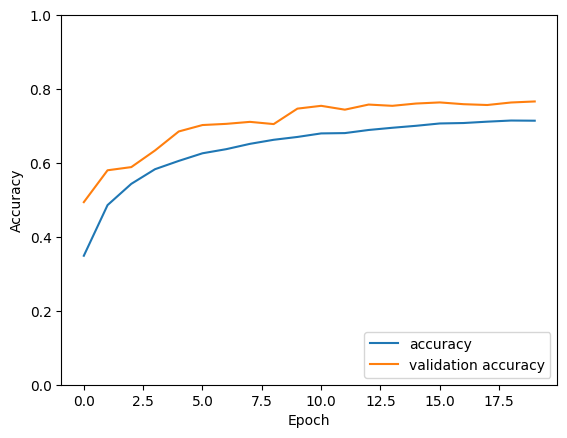

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,070,431 (4.08 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 713,621 (2.72 MB)

In [19]:
### 3 layer CNN with relu activation function
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to a 0-1 range by dividing by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Set up learning rate decay for better convergence in later epochs
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # Start at 0.001
    decay_steps=10000,           # Decay every 10,000 steps
    decay_rate=0.9,              # Decay rate of 90% of previous value
    staircase=True)              # Apply decay in a staircase function fashion

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # 20% dropout to prevent overfitting

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Increasing dropout for deeper layers

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Higher dropout for the deepest layer

    Flatten(),     # Flatten the output to feed into the dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout in fully connected layer
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model with the Adam optimizer and a learning rate schedule
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
model.summary()

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.3410 - loss: 1.8198 - val_accuracy: 0.5952 - val_loss: 1.1752
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5472 - loss: 1.2743 - val_accuracy: 0.6348 - val_loss: 1.0332
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5940 - loss: 1.1617 - val_accuracy: 0.6572 - val_loss: 0.9897
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6192 - loss: 1.0792 - val_accuracy: 0.6948 - val_loss: 0.8864
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6377 - loss: 1.0352 - val_accuracy: 0.6556 - val_loss: 0.9905
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6501 - loss: 0.9887 - val_accuracy: 0.7076 - val_loss: 0.8525
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6614 - loss: 0.9654 - val_accuracy: 0.7228 - val_loss: 0.8013
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6726 - loss: 0.9377 - 

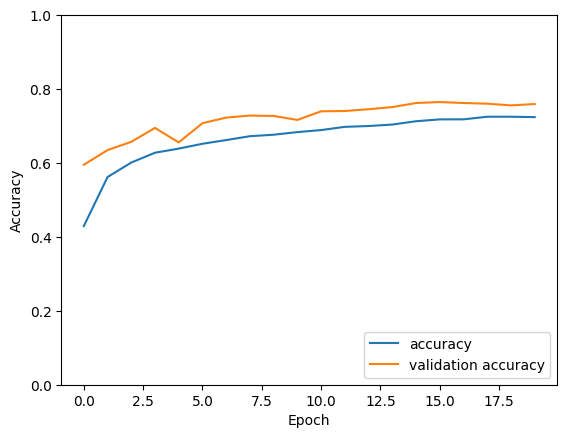

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,070,431 (4.08 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 713,621 (2.72 MB)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

# # Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to a 0-1 range by dividing by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train = tf.squeeze(tf.one_hot(y_train, num_classes), axis=1)
y_test = tf.squeeze(tf.one_hot(y_test, num_classes), axis=1)

# Set up learning rate decay for better convergence in later epochs
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # Start at 0.001
    decay_steps=10000,           # Decay every 10,000 steps
    decay_rate=0.9,              # Decay rate of 90% of previous value
    staircase=True)              # Apply decay in a staircase function fashion

# Build the CNN model
model1 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='elu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # 20% dropout to prevent overfitting

    Conv2D(64, (3, 3), padding='same', activation='elu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Increasing dropout for deeper layers

    Conv2D(128, (3, 3), padding='same', activation='elu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Higher dropout for the deepest layer

    Flatten(),     # Flatten the output to feed into the dense layers
    Dense(128, activation='elu'),
    Dropout(0.5),  # Dropout in fully connected layer
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model with the Adam optimizer and a learning rate schedule
model1.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model1.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.3734 - loss: 2.1741 - val_accuracy: 0.6270 - val_loss: 1.1272
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.6117 - loss: 1.1798 - val_accuracy: 0.6824 - val_loss: 0.9994
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.6819 - loss: 0.9695 - val_accuracy: 0.6750 - val_loss: 1.0490
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.7251 - loss: 0.8477 - val_accuracy: 0.7422 - val_loss: 0.8428
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.7594 - loss: 0.7616 - val_accuracy: 0.7020 - val_loss: 0.9374
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.7794 - loss: 0.7088 - val_accuracy: 0.7892 - val_loss: 0.7055
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 67ms/step - accuracy: 0.8003 - loss: 0.6568 - val_accuracy: 0.7754 - val_loss: 0.7649
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.8140 - loss: 0.6229 - 

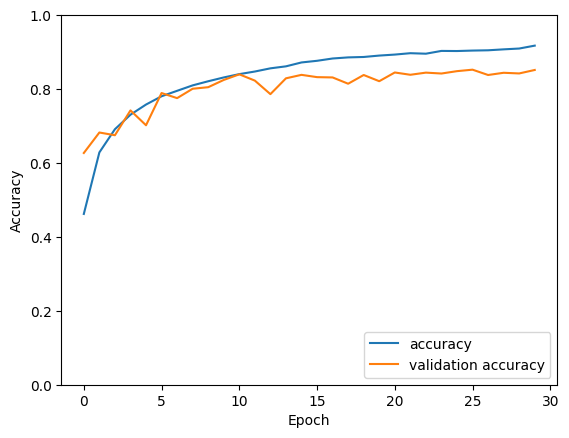

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to a 0-1 range by dividing by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set up learning rate decay for better convergence in later epochs
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # Start at 0.001
    decay_steps=10000,           # Decay every 10,000 steps
    decay_rate=0.9,              # Decay rate of 90% of previous value
    staircase=True)              # Apply decay in a staircase function fashion

# Weight decay for L2 regularization
weight_decay = 1e-4 

# Build the CNN model
model2 = Sequential([
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('elu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(num_classes, activation='softmax')
])

model2.summary()

# Compile the model with the Adam optimizer and a learning rate schedule
model2.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model2.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.1)

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.3696 - loss: 2.2951 - val_accuracy: 0.5188 - val_loss: 1.5418
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.6031 - loss: 1.2360 - val_accuracy: 0.6774 - val_loss: 0.9611
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.6779 - loss: 0.9866 - val_accuracy: 0.6898 - val_loss: 0.9650
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.7284 - loss: 0.8355 - val_accuracy: 0.7400 - val_loss: 0.7938
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.7495 - loss: 0.7712 - val_accuracy: 0.7824 - val_loss: 0.7192
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.7719 - loss: 0.7239 - val_accuracy: 0.6996 - val_loss: 1.0006
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.7935 - loss: 0.6701 - val_accuracy: 0.7942 - val_loss: 0.7024
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.8089 - loss: 0.6291 - 

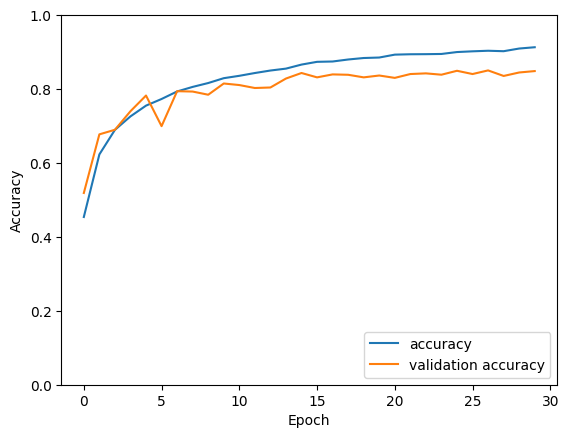

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to a 0-1 range by dividing by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set up learning rate decay for better convergence in later epochs
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # Start at 0.001
    decay_steps=10000,           # Decay every 10,000 steps
    decay_rate=0.9,              # Decay rate of 90% of previous value
    staircase=True)              # Apply decay in a staircase function fashion

# Weight decay for L2 regularization
weight_decay = 1e-4 

# Build the CNN model
model3 = Sequential([
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(num_classes, activation='softmax')
])

model3.summary()

# Compile the model with the Adam optimizer and a learning rate schedule
model3.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model3.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.1)

# Evaluate the model on the test data
test_loss, test_accuracy = model3.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
T